In [1]:
import numpy as np
import torch
from atari_py import import_roms
from PIL import Image
import torch.nn as nn
import copy
from torch.optim import RMSprop
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from tqdm import tqdm as tq
from gym.core import Env
from torch.distributions import Categorical
from torch.utils.data import Dataset,DataLoader
import pdb
import random
from torch.optim import Adam,AdamW


D:\Anaconda3\envs\SKYNET\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\Anaconda3\envs\SKYNET\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [14]:

env=gym.make('Breakout-v0')
rew_trajs=[]
for ep in tq(range (5)):
    env.reset()
    done=False
    ep_rew=0
    ep_rews=[]
    while not done:
        frame,rew,done,_=env.step(random.sample([2,3],1))
        ep_rew+=rew
        ep_rews.append(rew)
    rew_trajs.append(ep_rews)
    
    


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:21<00:00, 16.36s/it]


In [15]:
Env

gym.core.Env

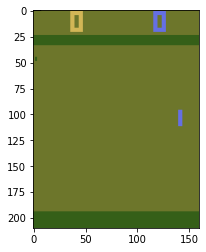

In [49]:
plt.imshow(env.reset())


In [7]:
c=Categorical(torch.tensor([0.5,0.5]))
c.sample()

tensor(1)

In [13]:
env

{'ALLUSERSPROFILE': 'C:\\ProgramData',
 'APPDATA': 'C:\\Users\\ANANYA\\AppData\\Roaming',
 'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files',
 'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files',
 'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files',
 'COMPUTERNAME': 'LAPTOP-VDF6TFBH',
 'COMSPEC': 'C:\\WINDOWS\\system32\\cmd.exe',
 'CONDA_DEFAULT_ENV': 'SKYNET',
 'CONDA_EXE': 'D:\\Anaconda3\\Scripts\\conda.exe',
 'CONDA_PREFIX': 'D:\\Anaconda3\\envs\\SKYNET',
 'CONDA_PREFIX_1': 'D:\\Anaconda3',
 'CONDA_PROMPT_MODIFIER': '(SKYNET) ',
 'CONDA_PYTHON_EXE': 'D:\\Anaconda3\\python.exe',
 'CONDA_SHLVL': '2',
 'CONFIGSETROOT': 'C:\\WINDOWS\\ConfigSetRoot',
 'CUDA_PATH': 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.1',
 'CUDA_PATH_V10_1': 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.1',
 'DRIVERDATA': 'C:\\Windows\\System32\\Drivers\\DriverData',
 'GPU_FORCE_64BIT_PTR': '0',
 'GPU_MAX_ALLOC_PERCENT': '100',
 'GPU_MAX_HEAP_SIZE': '100',
 'GP

In [8]:
class atari_env_wrapper(Env):
    
    """ Wrapper Class to wrap around actual env and 
    return processed next state,done and reward info
    so Qnet can ingest processed environment state to produce
    actions. Example:
    
    In Atari games the Kframes argument sets the number of frames
    to be used by the agent to produce an action.the agent repeats
    the action chosen for kframes=4 consecutive atari frames
    and concats the 4 produced observation into one tensor(frames) of
    shape 4 by 84 by 84 -4 greyscale images of size 4 by 4.
    
    The reset() method resets the wrapped atari env and also executes
    a random action kframes=4 times to produce the first video"""
    
   
    def __init__(self,env,kframes=4):
        self.env=env
        self.kframes=k_frames
        self.action_space=self.env.action_space
        
        
    def preproc(self,frames):
        out=torch.tensor(np.transpose(frames,(0,3,1,2)))/255.
        out=TF.rgb_to_grayscale(out)
        out=out.squeeze()
        out=TF.resize(out,(110,84))
        out=TF.crop(out,top=110-84,left=0,height=84,width=84)
        return out
        
    def step(self,action):
        frames,rews,dones=[],0,[]
        for i in range(self.kframes):
            frame,rew,done,_=self.env.step(action)
            frames.append(frame)
            rews+=rew
            dones.append(done)
        return (self.preproc(np.stack(frames)),rews,any(dones))
    
    ## take 1 random step to produce k=4 frames for input to the Qnet
    def reset(self):
        self.env.reset()
        init_act=self.env.action_space.sample()
        return self.step(init_act)
        
        
        
        
class Q_net(nn.Module):
    
    
    
    def __init__(self,n_actions=4,act=nn.ReLU()):
        super(Q_net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(4, 16, 8, 4),act)
      
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 4, 2),act)
        self.pool1=nn.AdaptiveAvgPool2d(1)
        self.fc1=nn.Sequential(nn.Linear(32,256),act)
        self.fc2=nn.Linear(256,n_actions)
        
    
    def forward(self, x):
        out=self.conv1(x)
        out=self.conv2(out)
        out=self.pool1(out)
        out=out.squeeze()
        out=self.fc1(out)
        out=self.fc2(out)
        return out
        
            
        
class pi_net(nn.Module):
    """ Simple Convnet architecture replresents a policy network,i.e the probability of taking one of 4 actions
    given a state (concatenation of 4 consecutive atari frames"""
    
    def __init__(self,n_actions,act=nn.ReLU(),kframes=2):
        super(pi_net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(kframes, 16, 8, 4),act)
      
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 4, 2),act)
        self.pool1=nn.AdaptiveAvgPool2d(1)
        self.fc1=nn.Sequential(nn.Linear(32,256),act)
        self.fc2=nn.Linear(256,n_actions)
        
    
    def forward(self, x):
        out=self.conv1(x)
        out=self.conv2(out)
        out=self.pool1(out)
        out=out.squeeze()
        out=self.fc1(out)
        out=self.fc2(out)
        return out
        
            
            


class atari_VPG():
    """ The Class implements Vanilla Policy Gradient algorithm for atari games.Experiance is generated by a ConvNet Policy,defined by the nn Module
        pi_net.baseline b for normlizing monte carlo returns (discounted sum of rewards till end of the episode) is taken as 0.An episode of experiance 
        is generated and then a policy gradient in estimated (gradient of expected sum of rewards starting in the init state distribution and ending with episode
        wrt. the policy parameters.
            """
    def __init__(self,pi_net_arch,device=torch.device('cuda'),batch_size=32,kframes=2,
                 env_wrapper=atari_env_wrapper,gamma=0.99,policy_loss=nn.CrossEntropyLoss(reduction='none')):
       
        self.batch_size=batch_size
        self.env_wrapper=env_wrapper(env=gym.make('Pong-v0'),kframes=kframes)
         ## selecting only the up and down actions as valid
        self.valid_actions=[2,3]
        self.n_actions=len(self.valid_actions)
        self.device=torch.device('cpu') if not torch.cuda.is_available() else device
        print(f'using device:{self.device}')
        self.pi_net=pi_net_arch(n_actions=self.n_actions,kframes=kframes).to(device)
        self.gamma=gamma
        ## selecting only the up and down actions as valid
        
        self.policy_loss=policy_loss.to(self.device)
        
    ## torch.utils.dataset wrapped around trajectory input frames and targets,to create Dataloaders from
    class trajectory_dataset(Dataset):
        def __init__(self,trajectory):
            self.trajectory=trajectory
        def __len__(self):
            return len(self.trajectory)
        def __getitem__(self,idx):
            return self.trajectory[idx]
            
            
        
    def pi_forward(self,proc_frames_batch):
        return self.pi_net(proc_frames_batch.to(self.device))
        
        
    def select_action(self,proc_frames_batch):
        ## act wrt the current policy (pi_net)
        with torch.no_grad():
            ## policy net takes batch of input states to prescribe actions,
            ## hence for a single state have to pre append a leading dim 
            probs = F.softmax(self.pi_forward(proc_frames_batch.unsqueeze(0)),dim=0)
        # sample action from current policy i.e pi a|s
        m = Categorical(probs)
        action_index=m.sample()
        action =self.valid_actions[action_index]
        return action,action_index
    
    def sample_rollout(self):
        proc_frames_batch,rew,done=self.env_wrapper.reset()
        ep_act_inds,ep_rews,ep_frames,d_factors=[],[],[],[]
        d_factor,total_epi_rew=1,0
        while not done:
            action,action_index=self.select_action(proc_frames_batch)
            proc_frames,rew,done=self.env_wrapper.step(action)
            ep_frames.append(proc_frames)
            ep_act_inds.append(action_index)
            ep_rews.append(rew*d_factor)
            d_factors.append(d_factor)
            d_factor*=self.gamma
            total_epi_rew+=rew
        
        ep_rews,d_factors=(torch.tensor(x) for x in [ep_rews,d_factors])
        ## reverse because the expected sum of future reward is the sum of discounted reward from each timestep onward
        pi_targets=ep_rews.sum()-torch.cumsum(ep_rews,dim=0)
        ## rescale takgets by removing extra gamma powers (discount factor terms)- not because sutton and bartp has extra gamma**t term for each time t
        ## apart from return 
        ##pi_targets=pi_targets/d_factors
        return list(zip(ep_frames,ep_act_inds,pi_targets)),total_epi_rew
            
        
        
    def train(self,n_episodes,optimizer_cls=RMSprop,lr=0.001):
        optimizer=optimizer_cls(self.pi_net.parameters(),lr)
        for n in tq(range(n_episodes),position=0,leave=True):
            trajectory,total_rew=self.sample_rollout()
            traj_ds=self.trajectory_dataset(trajectory)
            traj_dl=DataLoader(dataset=traj_ds,batch_size=32)
            episode_loss=[]
            for proc_frames_batch,act_inds,pi_targets in traj_dl:
                out=self.pi_forward(proc_frames_batch)
                try:
                    policy_loss=-(self.policy_loss(out,act_inds.to(self.device))*pi_targets.to(self.device)).mean()
                ## to cover the case when dataloader returns single item-frames and actions
                except:
                    policy_loss=-(self.policy_loss(out.unsqueeze(0),act_inds.to(self.device))*pi_targets.to(self.device)).mean()
                optimizer.zero_grad()
                policy_loss.backward()
                optimizer.step()
                episode_loss.append(policy_loss)
            if n%50==0:
                print({'episode':n,'episode_reward':total_rew,'episode_length':len(trajectory),'episode_loss':torch.stack(episode_loss).detach().mean().cpu().item()})
            
          
           
          
    
   
                    
                    

            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
                    
                    
                    
                
                
                
                
                
                
            
            
            
            
        
        
        
        
        
        
        
        
        
        
        
    
        

In [9]:
VPG=atari_VPG(pi_net_arch=pi_net,gamma=0.99)

using device:cuda


In [74]:
__name__

'__main__'

In [10]:
VPG.train(300,lr=0.00001,optimizer_cls=Adam)

  0%|▎                                                                                 | 1/300 [00:05<28:57,  5.81s/it]

{'episode': 0, 'episode_reward': -21.0, 'episode_length': 750, 'episode_loss': 0.24956922233104706}


 17%|█████████████▊                                                                   | 51/300 [05:56<26:45,  6.45s/it]

{'episode': 50, 'episode_reward': -21.0, 'episode_length': 622, 'episode_loss': 0.35361385345458984}


 21%|████████████████▋                                                                | 62/300 [07:17<27:59,  7.06s/it]


KeyboardInterrupt: 

In [57]:
rews=[]
steps=[]
for i in range (10):
    traj,rew=VPG.sample_rollout()
    rews.append(rew)
    steps.append(len(traj))
    
rews,steps

([-21.0, -21.0, -21.0, -21.0, -21.0, -20.0, -21.0, -21.0, -21.0, -21.0],
 [354, 335, 314, 379, 295, 369, 297, 254, 337, 357])

In [ ]:
1

In [26]:
loss = nn.CrossEntropyLoss(reduction='none')
inp = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(inp, target)

In [28]:
inp.shape

torch.Size([3, 5])

In [30]:
target

tensor([0, 2, 3])

In [31]:
inp

tensor([[-1.8331,  1.2661,  1.3427,  0.2605, -1.5767],
        [ 1.0396, -0.2459,  0.0255,  0.0121,  1.4747],
        [-0.2219,  1.2437, -0.5815,  0.1338, -0.1861]], requires_grad=True)

In [32]:
output

tensor([4.0349, 2.2789, 1.7834], grad_fn=<NllLossBackward0>)

In [33]:
inp[0].shape

torch.Size([5])

In [47]:
output = loss(inp[0].unsqueeze(0), target[0].unsqueeze(0))

In [48]:
output

tensor([4.0349], grad_fn=<NllLossBackward0>)

In [38]:
output

tensor([4.0349], grad_fn=<NllLossBackward0>)

In [46]:
torch.log(F.softmax(inp,dim=1))[0][0]

tensor(-4.0349, grad_fn=<SelectBackward0>)

In [40]:
inp.shape

torch.Size([3, 5])

In [22]:
1

1

In [23]:
torch.cat((torch.tensor([]),torch.tensor([5])))

tensor([5.])

In [15]:
list(reversed(l))

[3, 2, 1]

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_15808/1533538188.py, line 2)

In [4]:
z=zip([1,2,3],np.ones(3))

In [7]:
ar=np.array([1.,2.,3.])

In [14]:
np.array(list(reversed([1.,2.,3.])))

array([3., 2., 1.])

tensor([10.,  4.], grad_fn=<FlipBackward0>)

In [25]:
t

tensor([ 4., 10.], requires_grad=True)

TypeError: Dataset() takes no arguments

TypeError: 'Dataset' object is not callable